In [6]:
import argparse
import pickle

import numpy as np
from DA_PoC.dynamical_systems.lorenz_numerical_model import (
    LorenzWrapper,
    burn_model,
    create_lorenz_model_observation,
)

from DA_PoC.common.observation_operator import (
    IdentityObservationOperator,
)

from omegaconf import OmegaConf
from tqdm.rich import tqdm


def generate_datapoint(x_current, lorenz, time_window):
    n = lorenz.state_dimension
    history = lorenz.lorenz_model.integrate(0, x_current, time_window)
    tlm = lorenz.lorenz_model.construct_tlm_matrix(0, x_current, time_window)
    tlm = tlm.reshape(-1, n)
    return (x_current, history[1], tlm), (history[1][:, -1])





# def generate_datapoint_GNmatrix(x_current, lorenz, time_window):
#     n = lorenz.state_dimension
#     history = lorenz.lorenz_model.integrate(0, x_current, time_window)
#     return (x_current, history[1], tlm), (history[1][:, -1])


def generate_dataset(lorenz, x0, assimilation_window, nsamples):
    train = []
    x = x0
    for _ in tqdm.trange(nsamples):
        datapoint, x = generate_datapoint(
            x_current=x, lorenz=lorenz, nobs=assimilation_window
        )
        train.append(datapoint)
    return train


In [7]:
assimilation_window = [0.05, 0.4, 0.6, 0.8]  # 6 hours, 48 hours, 72 hours, 96 hours
def get_lorenz_model(dim):
    lorenz = LorenzWrapper(dim)
    F = 8
    sigma_b_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
    charac_length = 1.5
    background_correlation = lambda x, y: np.exp(-((x - y) ** 2) / charac_length**2)
    x, y = np.meshgrid(np.arange(dim), np.arange(dim))

    B = sigma_b_sq * background_correlation(x, y)
    B_half = np.linalg.cholesky(B)
    B_inv = np.linalg.inv(B)

    sigma_obs_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
    R = sigma_obs_sq * np.eye(dim)
    R_half = np.linalg.cholesky(R)

    lorenz.background_error_cov_inv = B_inv
    lorenz.background = np.zeros(dim)

    lorenz.create_and_burn_truth()
    return lorenz

In [8]:
n = 15
lolo = get_lorenz_model(n)

In [36]:
assimilation_window_timesteps = [
    int(window / lolo.lorenz_model.dt) for window in assimilation_window
]
print(assimilation_window_timesteps)
window = assimilation_window_timesteps[-1]
lolo.H = lambda x: x
lolo.set_observations(nobs=window)
m = n * (window + 1)
identity_obs_operator = IdentityObservationOperator(m)

identity_obs_operator = IdentityObservationOperator(m)
num_model = create_lorenz_model_observation(
    lolo, identity_obs_operator, test_consistency=False
)


[2, 20, 30, 40]
Observation operator set already
lorenz.cost_function(x0_t)=4618.209591212929
numerical_model_lorenz.cost_function(x0_t)=4618.209591212929


NameError: name 'plt' is not defined

In [40]:
num_model.obs_operator.H.shape

(615, 615)

In [41]:
num_model.tangent_linear(np.random.uniform(size=(n))).shape

(615, 15)

In [45]:
(num_model.obs_operator.H @ num_model.tangent_linear(np.random.uniform(size=(n))).matmat(np.eye(n))).shape

(615, 15)

In [48]:
tlm = num_model.tangent_linear(np.random.uniform(size=(n)))

In [49]:
tlm.shape

(615, 15)

In [105]:
HG = num_model.obs_operator.H @ tlm.matmat(np.eye(n))
HG.shape

(HG.reshape(n,  window + 1, n)[:, 0, :]).shape

idx_observed = [0, 10, 13]
obs_H = np.zeros((len(idx_observed), window + 1))
for i, idx in enumerate(idx_observed):
    obs_H[i, idx] = 1.0
obs_H.shape


(3, 41)

In [107]:
print((HG.reshape(n,  window + 1, n)[:, :, :]).shape)
AA = obs_H.reshape(1, 3, window + 1) @ (HG.reshape(n,  window + 1, n)[:, :, :])

(15, 41, 15)


In [108]:
AA.shape

(15, 3, 15)

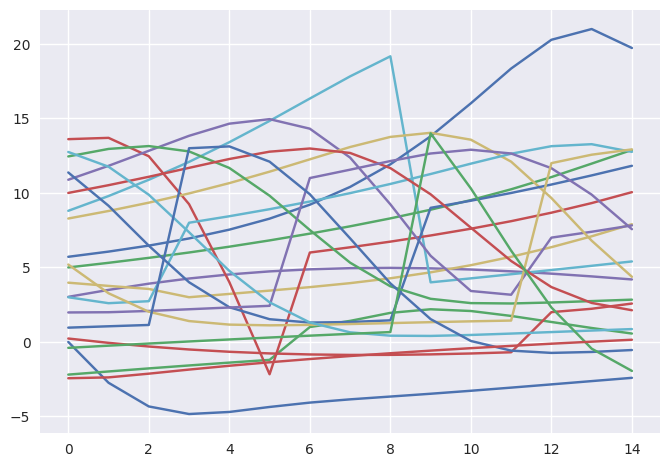

In [26]:
import matplotlib.pyplot as plt
plt.plot(num_model.forward(np.arange(n)).reshape(window + 1, n).T)

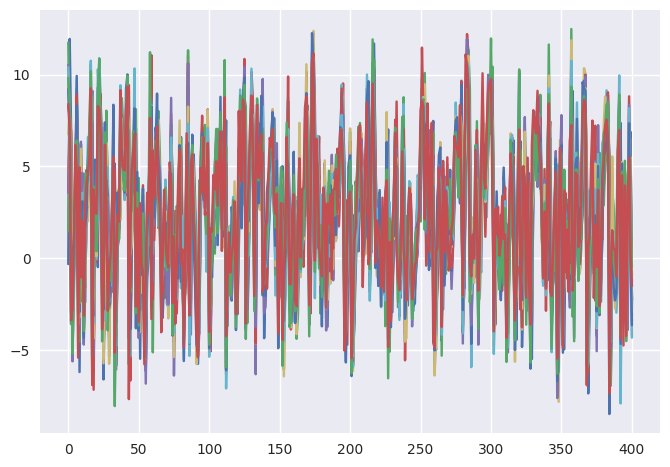

In [35]:
lolo.set_observations(nobs=20*window)
plt.plot(lolo.obs.reshape(20*window + 1, 15))